In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm


import pylab
import csv
import datetime
import math
import re
import time
import random
import os

from pandas.tseries.offsets import *
from operator import *
from statsmodels.tsa.deterministic import Fourier, CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn import manifold
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

%matplotlib inline

# plt.style.use('ggplot') # Good looking plots

np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 100)
pd.set_option('expand_frame_repr', False)
pd.options.display.precision = 6

start_time = time.time()

Populating the interactive namespace from numpy and matplotlib


In [35]:
# RMSPE метрика
# Thanks to Chenglong Chen for providing this in the forum

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    #y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [2]:
seed = 42

In [3]:
nrows = None

df_train = pd.read_csv('train.csv', 
                       nrows=nrows,
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

nrows = nrows

df_submit = pd.read_csv('test.csv', 
                        nrows=nrows,
                        parse_dates=['Date'],
                        date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

C:\Users\cassi\AppData\Local\Temp\ipykernel_5636\3576650018.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('train.csv',


In [4]:
### признак отличающий тренировочный набор от тестового

df_train['Set'] = 1
df_submit['Set'] = 0

In [5]:
### соединим последовательно train и test

frames = [df_train, df_submit]
df = pd.concat(frames)

In [6]:
features_x = ['Store', 'Date', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']

In [7]:
### удалим строки где магазин открыт но продаж нет (так как все дни когда продажи равны 0 не учитываются)

df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]

In [8]:
#прологарифмируем Sales и положим в новый столбец SalesLog

df.loc[df['Set'] == 1, 'SalesLog'] = np.log1p(df.loc[df['Set'] == 1]['Sales']) # = np.log(df['Sales'] + 1)

In [9]:
#превртим признак StateHoliday в категориальный

df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes

In [10]:
#для каждой даты создадим отдельный столбец для дня, недели, месяца, года, дня года и
#заполним пропуски нулями

var_name = 'Date'

df[var_name + 'Day'] = pd.Index(df[var_name]).day
df[var_name + 'Week'] = pd.Index(df[var_name]).week
df[var_name + 'Month'] = pd.Index(df[var_name]).month
df[var_name + 'Year'] = pd.Index(df[var_name]).year
df[var_name + 'DayOfYear'] = pd.Index(df[var_name]).dayofyear


features_x.remove(var_name)
features_x.extend([var_name + 'Day', 
                   var_name + 'Week', 
                   var_name + 'Month', 
                   var_name + 'Year', 
                   var_name + 'DayOfYear'])

C:\Users\cassi\AppData\Local\Temp\ipykernel_5636\1574438068.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df[var_name + 'Week'] = pd.Index(df[var_name]).week


In [11]:
#для каждой даты посчитаем эпохальное время - количество наносекунд от начала 1970 года

df['DateInt'] = df['Date'].astype(np.int64)

# Reading store data

In [18]:
df_store = pd.read_csv('store.csv', 
                       nrows=nrows)

In [19]:
### Конвертируем Storetype и Assortment в категориальные признаки

df_store['StoreType'] = df_store['StoreType'].astype('category').cat.codes
df_store['Assortment'] = df_store['Assortment'].astype('category').cat.codes

In [20]:
### метод который конвертирует столбцы открытия ближайшего конкурента CompetitionOpenSince[Month/Year] в дату

def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan

# создадим столбец CompetitionOpenInt - эпохальное время открытия ближайшего конкурента

df_store['CompetitionOpenInt'] = df_store.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)

In [21]:
#для каждого из 4 интервалов в PromoInterval создадим отдельный столбец

s = df_store['PromoInterval'].str.split(',').apply(pd.Series, 1)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
df_store = df_store.join(s)

In [22]:
# метод который возвращает номер месяца по его названию

def monthToNum(date):
    return{
            'Jan' : 1,
            'Feb' : 2,
            'Mar' : 3,
            'Apr' : 4,
            'May' : 5,
            'Jun' : 6,
            'Jul' : 7,
            'Aug' : 8,
            'Sept' : 9, 
            'Oct' : 10,
            'Nov' : 11,
            'Dec' : 12
    }[date]

#названия месяца преобразуем в номер

df_store['PromoInterval0'] = df_store['PromoInterval0'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval1'] = df_store['PromoInterval1'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval2'] = df_store['PromoInterval2'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval3'] = df_store['PromoInterval3'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

In [23]:
del df_store['PromoInterval']

In [24]:
#добавим полученные признаки в features_x (кроме Promo2SinceFloat, PromoInterval1, PromoInterval2, PromoInterval3)

store_features = ['Store', 'StoreType', 'Assortment', 
                  'CompetitionDistance', 'CompetitionOpenInt',
                  'PromoInterval0']

### Признаки которые не помогают
# PromoInterval1, PromoInterval2, PromoInterval3

features_x = list(set(features_x + store_features))

df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [25]:
### Convert every NAN to -1

for feature in features_x:
    df[feature] = df[feature].fillna(-1)

In [26]:
#у 622 магазина по какой-то причине некоторые значения Open которые должны быть равны 1 равны -1. Исправим это

df.loc[(df['Set'] == 0) & (df['Store'] == 622), 'Open'] = \
    df.loc[(df['Set'] == 0) & (df['Store'] == 622), 'Open'].replace(-1, 1)

In [27]:
#моменты времени для указанных рядов до которых элементы рассматривать не будем

store_dates_to_remove = {   105:1.368e18, 163:1.368e18,
                            172:1.366e18, 364:1.37e18,
                            378:1.39e18, 523:1.39e18,
                            589:1.37e18, 663:1.39e18,
                            676:1.366e18, 681:1.37e18,
                            700:1.373e18, 708:1.368e18,
                            709:1.423e18, 730:1.39e18,
                            764:1.368e18, 837:1.396e18,
                            845:1.368e18, 861:1.368e18,
                            882:1.368e18, 969:1.366e18,
                            986:1.368e18, 192:1.421e18,
                            263:1.421e18, 500:1.421e18,
                            797:1.421e18, 815:1.421e18,
                            825:1.421e18}

# создадим столбец Delete с пометкой на удаление значений ряда с датой меньшей указанной

for key, value in store_dates_to_remove.items():
    df.loc[(df['Store'] == key) & (df['DateInt'] < value), 'Delete'] = True

In [28]:
### удалим аномальные данные

df = df.loc[df['Delete'] != True]

## Удалим выбросы с отклонением >= 3

In [29]:
#метод считает для каждой точки модифицированный z-score и возвращает true если элемент - выброс

def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    
    median = np.median(points, axis=0)
    
    med_abs_deviation = np.median(np.absolute(points - median))

    modified_z_score = 0.6745 * (points - median) / med_abs_deviation

    return modified_z_score > thresh

In [30]:
#для каждого ряда пометим наблюдения выбросы

for i in df['Store'].unique():
    df.loc[(df['Set'] == 1) & (df['Store'] == i) & (df['Open'] == 1), 'Outlier'] = \
        mad_based_outlier(df.loc[(df['Set'] == 1) & (df['Store'] == i) & (df['Open'] == 1)]['Sales'], 3)

C:\Users\cassi\AppData\Local\Temp\ipykernel_5636\2863808409.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = points[:,None]
C:\Users\cassi\AppData\Local\Temp\ipykernel_5636\2863808409.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = points[:,None]


## Разделим данные в обучении и тест для заполнения выбросов

In [31]:
#поделим данные без выбросов на обучение и тест 

X_train, X_test, y_train, y_test = train_test_split(df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_x],
                                                    df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_y],
                                                    test_size=0.1, random_state=seed)

In [32]:
#Есть разные api для обучения xgboost, будем использовать тот, где обучающие данные нужно обернуть в DMatrix

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [33]:
num_round = 4000
evallist = [(dtrain, 'train'), (dtest, 'test')]

In [36]:
param = {'bst:max_depth':12,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1,
         'objective':'reg:linear',
         'nthread':6,
         'seed':seed}

# параметры:
# subsample – доля обучающей подвыборки дерева
# colsample_bytree – доля подмножества колонок для обучения дерева
# silent - нужно ли печатать диагностику
# objective - тип задачи и тип модели (reg - задача регрессии, linear - линейная регрессия)
# nthread - количество потоков

# обучим модель
# feval - метрика
# verbose_eval - количество шагов бустинга для которых будет выводиться метрика
# early_stopping_rounds - количество шагов бустинга в течении которых если не было ни одного улучшения
#    метрики, то обучение заканчивается
# 2 аргумент - тренировочный набор
# 3 аргумент - количество итераций бустинга
# 4 аргумент - тестовый набор


bst = xgb.train(param, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

C:\Users\cassi\anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
C:\Users\cassi\anaconda3\lib\site-packages\xgboost\training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[22:22:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bst:eta", "bst:max_depth", "silent" } are not used.

[0]	train-rmse:5.78877	train-rmspe:0.99680	test-rmse:5.78783	test-rmspe:0.99679
[250]	train-rmse:0.11904	train-rmspe:0.18581	test-rmse:0.12059	test-rmspe:0.13240
[500]	train-rmse:0.10107	train-rmspe:0.14049	test-rmse:0.10412	test-rmspe:0.11433
[750]	train-rmse:0.09358	train-rmspe:0.12809	test-rmse:0.09782	test-rmspe:0.10814
[1000]	train-rmse:0.08936	train-rmspe:0.11721	test-rmse:0.09478	test-rmspe:0.10518
[1250]	train-rmse:0.08631	train-rmspe:0.10514	test-rmse:0.09290	test-rmspe:0.10332
[1500]	train-rmse:0.08398	train-rmspe:0.09992	test-rm

In [37]:
# выбросы

dpred = xgb.DMatrix(df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True)][features_x])

In [38]:
#сделаем предсказания на выбросах

ypred_bst = bst.predict(dpred)

In [39]:
#добавим предсказания на выбросах в данные

df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True), 'SalesLog'] = ypred_bst
df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True), 'Sales'] = np.exp(ypred_bst) - 1

In [40]:
stores_N = df['Store'].unique()

In [41]:
df = df.sort_values(by=['Store', 'Date'])

In [43]:
#рассчет попарных расстояний (MSE) для определния похожих рядов

stores_metric = {}

for (i, store_1) in enumerate(stores_N):
    if (store_1 > 3):
        break
    print(store_1)
    for store_2 in stores_N[i + 1 :]:
        df_store_1 = df.loc[(df['Set'] == 1) & (df['Store'] == store_1)]['SalesLog'].to_numpy()
        df_store_2 = df.loc[(df['Set'] == 1) & (df['Store'] == store_2)]['SalesLog'].to_numpy()
        if len(df_store_1) != len(df_store_2):
            continue
        #print(np.mean((df_store_1 - df_store_2)**2))
        stores_metric[(store_1, store_2)] = np.mean((df_store_1 - df_store_2)**2)
      

1
2
3


In [44]:
sorted([(s, m) for (s, m) in stores_metric.items() if s[0] == 1], key = lambda item: item[1])

[((1, 601), 0.017502990222952753),
 ((1, 584), 0.019158840211231865),
 ((1, 130), 0.026454021409490543),
 ((1, 997), 0.02702330398900412),
 ((1, 337), 0.02858429166249208),
 ((1, 568), 0.03058286365733337),
 ((1, 285), 0.03234927744792702),
 ((1, 182), 0.0343248218112179),
 ((1, 451), 0.034545544061240566),
 ((1, 1083), 0.03616664676106501),
 ((1, 1103), 0.04154378385905903),
 ((1, 312), 0.043053452356125815),
 ((1, 409), 0.04361640754834974),
 ((1, 160), 0.04514067327835665),
 ((1, 481), 0.04650890140762667),
 ((1, 852), 0.049591551612560084),
 ((1, 829), 0.05371287929143207),
 ((1, 727), 0.057139104409860926),
 ((1, 135), 0.05799037685460569),
 ((1, 305), 0.05897834681158463),
 ((1, 773), 0.06430711931004705),
 ((1, 627), 0.06772320123138612),
 ((1, 242), 0.06856413290331245),
 ((1, 659), 0.06859954412802025),
 ((1, 942), 0.07059546662742935),
 ((1, 202), 0.07059694039722186),
 ((1, 550), 0.07192463290924767),
 ((1, 746), 0.0739595664616985),
 ((1, 235), 0.07680914764291777),
 ((1, 2

In [45]:
# метки - признаки StoreType

label_assortment = df[df['Set'] == 1].set_index(['Store', 'Date']).groupby('Store').first()['StoreType']

In [46]:
#метки - номера магазинов

label_stores = df[df['Set'] == 1].set_index(['Store', 'Date']).groupby('Store').first().index

In [47]:
# сделаем датафрейм где каждая строка - наблюдения ряда, чтобы сделать понижение размерности и визуализацию

data = df[df['Set'] == 1].set_index(['Store', 'Date'])['SalesLog'].unstack('Date')

In [48]:
data = data.fillna(0)

In [49]:
data

Date   2013-01-01  2013-01-02  2013-01-03  2013-01-04  2013-01-05  2013-01-06  2013-01-07  2013-01-08  2013-01-09  2013-01-10  2013-01-11  2013-01-12  2013-01-13  2013-01-14  2013-01-15  2013-01-16  2013-01-17  2013-01-18  2013-01-19  2013-01-20  2013-01-21  2013-01-22  2013-01-23  2013-01-24  2013-01-25  2013-01-26  2013-01-27  2013-01-28  2013-01-29  2013-01-30  2013-01-31  2013-02-01  2013-02-02  2013-02-03  2013-02-04  2013-02-05  2013-02-06  2013-02-07  2013-02-08  2013-02-09  2013-02-10  2013-02-11  2013-02-12  2013-02-13  2013-02-14  2013-02-15  2013-02-16  2013-02-17  2013-02-18  2013-02-19  2013-02-20  2013-02-21  2013-02-22  2013-02-23  2013-02-24  2013-02-25  2013-02-26  2013-02-27  2013-02-28  2013-03-01  2013-03-02  2013-03-03  2013-03-04  2013-03-05  2013-03-06  2013-03-07  2013-03-08  2013-03-09  2013-03-10  2013-03-11  2013-03-12  2013-03-13  2013-03-14  2013-03-15  2013-03-16  2013-03-17  2013-03-18  2013-03-19  2013-03-20  2013-03-21  2013-03-22  2013-03-23  2013-03-24  2013-03-25  2013-03-26  2013-03-27  2013-03-28  2013-03-29  2013-03-30  2013-03-31  2013-04-01  2013-04-02  2013-04-03  2013-04-04  2013-04-05  2013-04-06  2013-04-07  2013-04-08  2013-04-09  2013-04-10  2013-04-11  2013-04-12  2013-04-13  2013-04-14  2013-04-15  2013-04-16  2013-04-17  2013-04-18  2013-04-19  2013-04-20  2013-04-21  2013-04-22  2013-04-23  2013-04-24  2013-04-25  2013-04-26  2013-04-27  2013-04-28  2013-04-29  2013-04-30  2013-05-01  2013-05-02  2013-05-03  2013-05-04  2013-05-05  2013-05-06  2013-05-07  2013-05-08  2013-05-09  2013-05-10  2013-05-11  2013-05-12  2013-05-13  2013-05-14  2013-05-15  2013-05-16  2013-05-17  2013-05-18  2013-05-19  2013-05-20  2013-05-21  2013-05-22  2013-05-23  2013-05-24  2013-05-25  2013-05-26  2013-05-27  2013-05-28  2013-05-29  2013-05-30  2013-05-31  2013-06-01  2013-06-02  2013-06-03  2013-06-04  2013-06-05  2013-06-06  2013-06-07  2013-06-08  2013-06-09  2013-06-10  2013-06-11  2013-06-12  2013-06-13  2013-06-14  2013-06-15  2013-06-16  2013-06-17  2013-06-18  2013-06-19  2013-06-20  2013-06-21  2013-06-22  2013-06-23  2013-06-24  2013-06-25  2013-06-26  2013-06-27  2013-06-28  2013-06-29  2013-06-30  2013-07-01  2013-07-02  2013-07-03  2013-07-04  2013-07-05  2013-07-06  2013-07-07  2013-07-08  2013-07-09  2013-07-10  2013-07-11  2013-07-12  2013-07-13  2013-07-14  2013-07-15  2013-07-16  2013-07-17  2013-07-18  2013-07-19  2013-07-20  2013-07-21  2013-07-22  2013-07-23  2013-07-24  2013-07-25  2013-07-26  2013-07-27  2013-07-28  2013-07-29  2013-07-30  2013-07-31  2013-08-01  2013-08-02  2013-08-03  2013-08-04  2013-08-05  2013-08-06  2013-08-07  2013-08-08  2013-08-09  2013-08-10  2013-08-11  2013-08-12  2013-08-13  2013-08-14  2013-08-15  2013-08-16  2013-08-17  2013-08-18  2013-08-19  2013-08-20  2013-08-21  2013-08-22  2013-08-23  2013-08-24  2013-08-25  2013-08-26  2013-08-27  2013-08-28  2013-08-29  2013-08-30  2013-08-31  2013-09-01  2013-09-02  2013-09-03  2013-09-04  2013-09-05  2013-09-06  2013-09-07  2013-09-08  2013-09-09  2013-09-10  2013-09-11  2013-09-12  2013-09-13  2013-09-14  2013-09-15  2013-09-16  2013-09-17  2013-09-18  2013-09-19  2013-09-20  2013-09-21  2013-09-22  2013-09-23  2013-09-24  2013-09-25  2013-09-26  2013-09-27  2013-09-28  2013-09-29  2013-09-30  2013-10-01  2013-10-02  2013-10-03  2013-10-04  2013-10-05  2013-10-06  2013-10-07  2013-10-08  2013-10-09  2013-10-10  2013-10-11  2013-10-12  2013-10-13  2013-10-14  2013-10-15  2013-10-16  2013-10-17  2013-10-18  2013-10-19  2013-10-20  2013-10-21  2013-10-22  2013-10-23  2013-10-24  2013-10-25  2013-10-26  2013-10-27  2013-10-28  2013-10-29  2013-10-30  2013-10-31  2013-11-01  2013-11-02  2013-11-03  2013-11-04  2013-11-05  2013-11-06  2013-11-07  2013-11-08  2013-11-09  2013-11-10  2013-11-11  2013-11-12  2013-11-13  2013-11-14  2013-11-15  2013-11-16  2013-11-17  2013-11-18  2013-11-19  2013-11-20  2013-11-21  2013-11-22  2013-11-23  2013-11-24  2013-11-25  2013-11-26  2013-11-27  2013-11-28  2013-11-2

In [50]:
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
data_2d_tsne = tsne.fit_transform(data)

C:\Users\cassi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\cassi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\cassi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [51]:
pylab.figure(figsize = (200, 120))
pylab.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c = label_assortment)

for i, xy in enumerate(data_2d_tsne):
    plt.annotate(text=label_stores[i], xy=(xy[0], xy[1]))

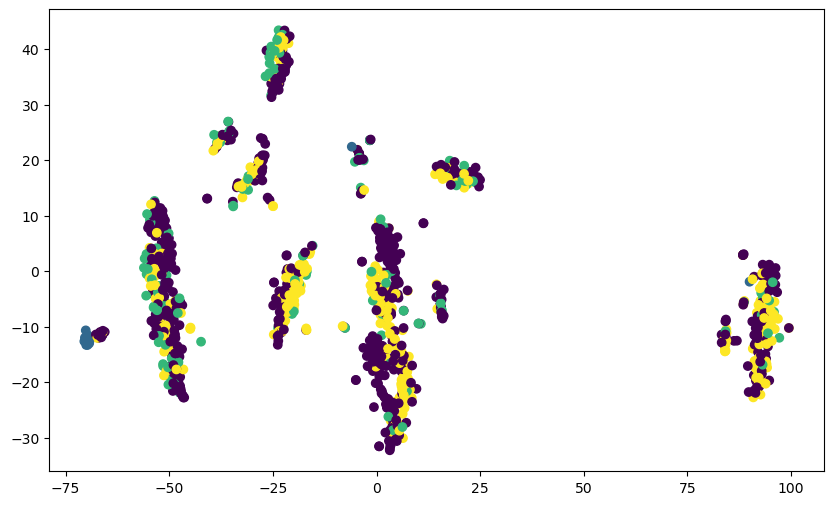

In [52]:
pylab.figure(figsize = (10, 6))
pylab.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c = label_assortment)


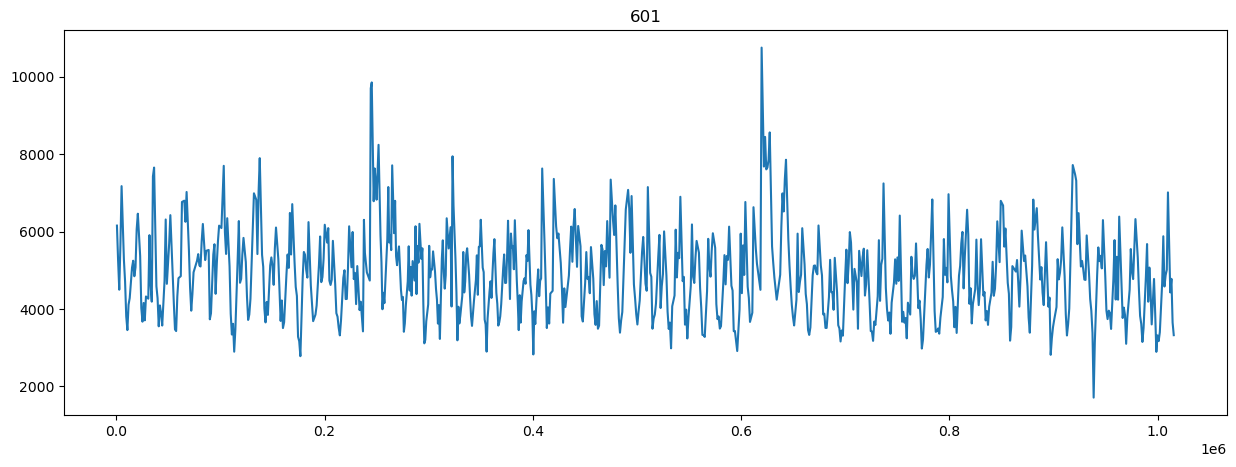

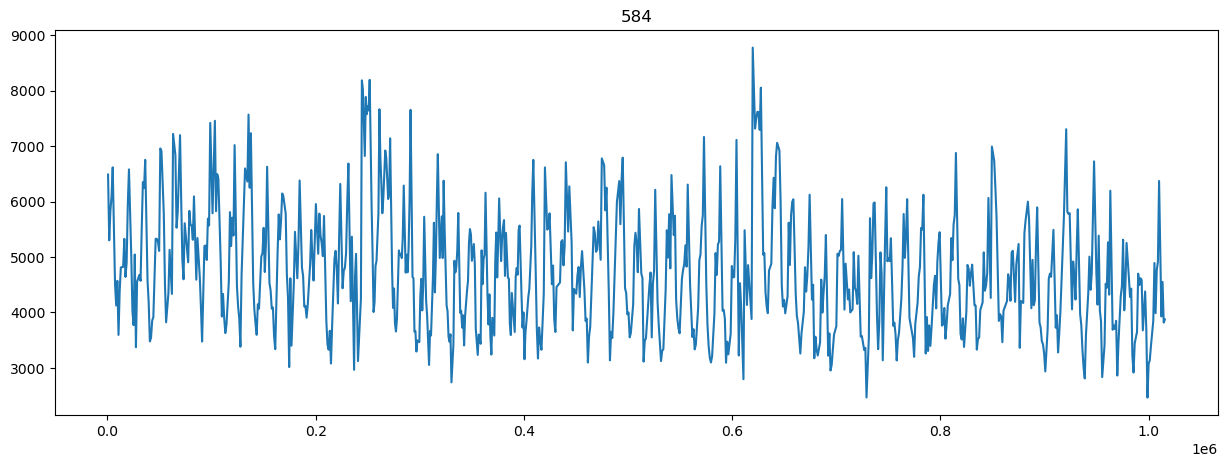

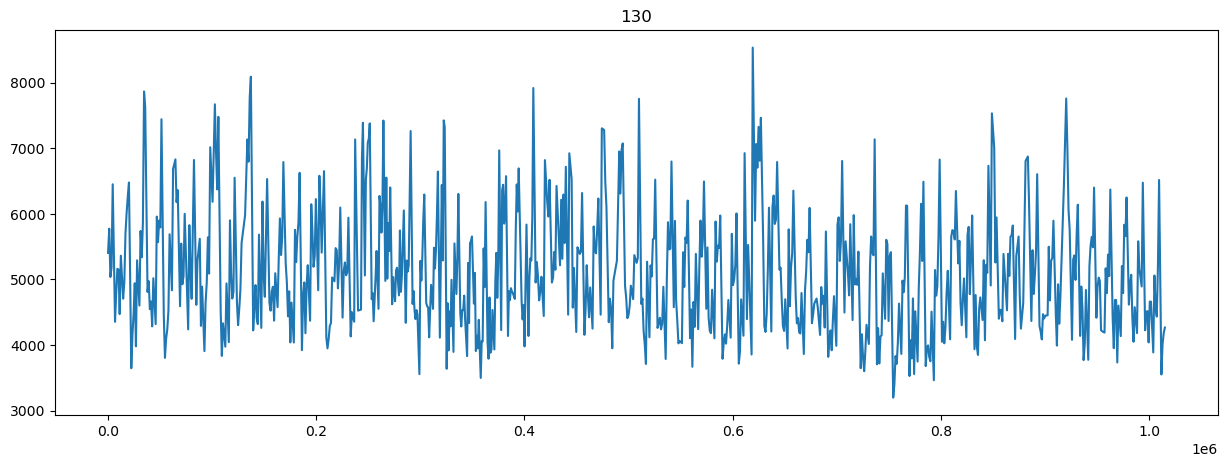

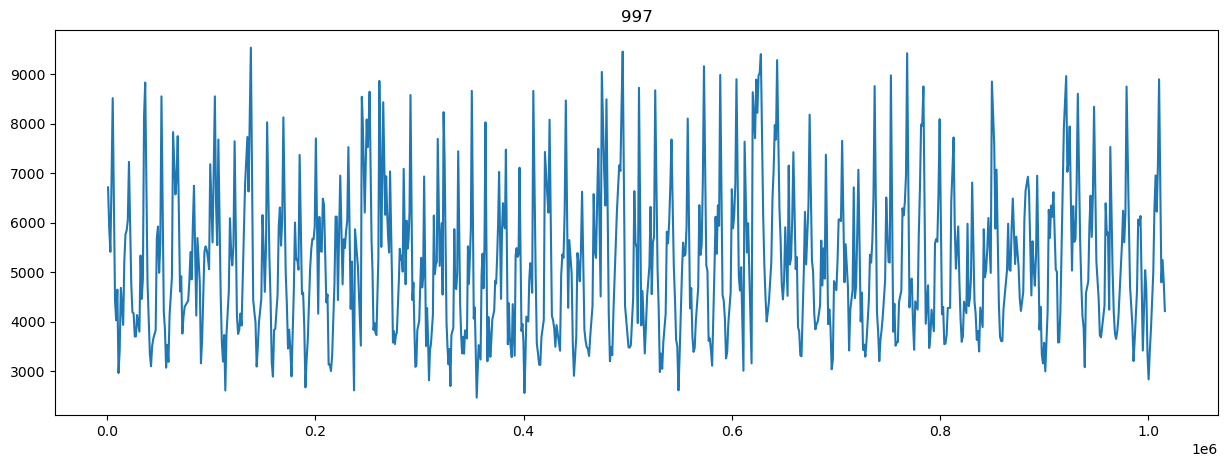

In [53]:
series_cluster1 = [601, 584, 130, 997]

for i in series_cluster1:
    plt.figure(figsize(15,5))
    df[(df['Store'] == i) & (df['Open'] == 1)]['Sales'].plot(title=i)